In [1]:
import pandas as pd
import numpy as np
import time

In [2]:
ratings = pd.read_csv("./ml-latest-small/ratings.csv")
ratings[ratings.userId==1].head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [3]:
movies = pd.read_csv('./ml-latest/movies.csv', encoding='latin-1')
print (movies.shape)
movies.head()

(58098, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
num_users = ratings.userId.unique().shape[0]
num_items = ratings.movieId.unique().shape[0]
num_users, num_items

(610, 9724)

In [5]:
from sklearn import model_selection as ms
train_set, test_set = ms.train_test_split(ratings, test_size=0.25)
len(train_set), len(test_set)

(75627, 25209)

In [6]:
user_movie_matrix = train_set.pivot(index='userId', columns='movieId', values='rating')
print("UM Matrix value size", user_movie_matrix.values.size)
print("ratings value size", ratings.values.size)
print("Sparisity: {:4.2f}%".format(ratings.rating.values.size/user_movie_matrix.values.size*100))
user_movie_matrix.head(10)

UM Matrix value size 5369220
ratings value size 403344
Sparisity: 1.88%


movieId,1,2,3,4,5,6,7,8,9,10,...,190209,190215,190221,193565,193571,193573,193579,193581,193583,193585
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,4.0,5.0,3.0,NaN,4.0,4.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# similarity
import math
from operator import itemgetter
from scipy.spatial import distance

def distance_cosine(a,b):
    return 1-distance.cosine(a,b)

def disance_corr(a,b):
    return 1-distance.correlation(a,b)

def distance_euclidean(a,b):
    return 1/(distance.euclidean(a,b)+1)

In [8]:
def nearest_neighbor_user(user, topN, simFunc) :  
    u1 = user_movie_matrix.loc[user].dropna()
    ratedIndex = u1.index
    nn = {}
    
    # Brute-Force Compute
    for uid, row in user_movie_matrix.iterrows():
        interSectionU1 = []
        interSectionU2 = []
        if uid==user:
            continue
            
        for i in ratedIndex:
            if False==math.isnan(row[i]):
                interSectionU1.append(u1[i])
                interSectionU2.append(row[i])
        interSectionLen = len(interSectionU1)
        
        # at least 3 intersection items
        if interSectionLen < 3 :
            continue
            
        # similarity functon
        sim = simFunc(interSectionU1, interSectionU2)
        
        if  math.isnan(sim) == False:
            nn[uid] = sim
            
    # top N returned         
    return sorted(nn.items(),key=itemgetter(1),reverse=True)[:(topN+1)]

In [9]:
def nearest_neighbor_item(movie, topN, simFunc):
    m1 = user_movie_matrix[movie].dropna()
    user_index = m1.index
    nn = {}
    
    for movieId, col in user_movie_matrix.iteritems():
        interSectionU1 = []
        interSectionU2 = []
        if movie == movieId:
            continue
        
        for i in user_index:
            if False==math.isnan(col[i]):
                interSectionU1.append(m1[i])
                interSectionU2.append(col[i])
        interSectionLen = len(interSectionU1)
        
        # at least 3 intersection items
        if interSectionLen < 3:
            continue
            
        # similarity functon
        sim = simFunc(interSectionU1, interSectionU2)
        
        if  math.isnan(sim) == False:
            nn[movieId] = sim
            
    # top N returned         
    return sorted(nn.items(),key=itemgetter(1),reverse=True)[:(topN+1)]

In [10]:
print(pd.DataFrame(nearest_neighbor_user(278, 100, distance_euclidean), columns=['userId', 'sim']).head())
print(pd.DataFrame(nearest_neighbor_item(1, 100, distance_euclidean), columns=['movieId', 'sim']).head())

   userId  sim
0       8  1.0
1      15  1.0
2     348  1.0
3     373  1.0
4     512  1.0
   movieId  sim
0      233  1.0
1      948  1.0
2     2662  1.0
3     3068  1.0
4     3341  1.0


In [11]:
def predictRating(id_num, nn=50, simFunc=distance_euclidean, kind = 'user') :
   
    if (kind == "user"):
        ## neighboorhood 
        neighbor = nearest_neighbor_user(id_num, nn, simFunc)

        neighbor_id = [id for id, sim in neighbor]
        # List of similar similarities

        ## Remove if two or more are NaN
        neighbor_movie = user_movie_matrix.loc[neighbor_id].dropna(1, how = 'all', thresh = 2)
        # User id x DataFrame of movie id. However, if the NaN of the column is 2 or more, it is deleted.

        neighbor_dic = dict(neighbor)
        ret = [] 
        #['movieId', 'predictedRate']

        # iterate through each column key: userid, column: movieid, value: rating
        for movieId, row in neighbor_movie.iteritems():
            jsum, wsum = 0, 0
            for v in row.dropna().iteritems():
                sim = neighbor_dic.get(v[0],0)
                jsum += sim
                wsum += (v[1]*sim)
            ret.append([movieId, wsum/jsum])

        return ret
    
    elif (kind == 'item'):
        neighbor = nearest_neighbor_item(id_num, nn, simFunc)
        
        neighbor_id = [id for id, sim in neighbor]
        
        neighbor_ratedUser = user_movie_matrix[neighbor_id].dropna(0, how = 'all', thresh = 2)
        
        neighbor_dic = dict(neighbor)
        ret = []
        
        for userId, row in neighbor_ratedUser.iterrows():
            jsum, wsum = 0, 0
            for v in row.dropna().iteritems():
                sim = neighbor_dic.get(v[0], 0)
                jsum += sim
                wsum += (v[1]*sim)
            ret.append([userId, wsum/jsum])
        
        return ret
        

In [12]:
# predictRating(1, 100, kind = 'user')
predictRating(1, 50, kind = 'item')

[[28, 2.659333542845812],
 [50, 3.25],
 [51, 4.595371784915272],
 [57, 5.0],
 [66, 4.0],
 [68, 2.733855637236537],
 [89, 3.4999999999999996],
 [91, 3.2],
 [95, 4.467711274473075],
 [105, 4.142857142857143],
 [113, 4.467711274473075],
 [140, 4.0],
 [156, 3.866927818618269],
 [177, 4.8996638569862085],
 [182, 4.143722443136612],
 [186, 4.0],
 [199, 4.021999371462563],
 [202, 4.0],
 [217, 4.0],
 [221, 4.7],
 [232, 3.25],
 [238, 3.935422548946149],
 [262, 3.0000000000000004],
 [274, 3.943364770084753],
 [275, 4.467711274473075],
 [279, 3.0000000000000004],
 [287, 3.214285714285715],
 [288, 4.0],
 [290, 4.0],
 [298, 2.0],
 [305, 3.4999999999999996],
 [309, 3.2338556372365375],
 [313, 4.042144440520923],
 [318, 3.652618519826359],
 [325, 3.428571428571429],
 [334, 3.4999999999999996],
 [357, 5.0],
 [368, 2.0],
 [380, 4.999999999999999],
 [387, 3.852013197212434],
 [391, 4.222222222222222],
 [414, 3.972994458619301],
 [422, 4.0],
 [448, 3.1710811895487834],
 [469, 3.8505311213075326],
 [474, 

In [13]:
## view rated movies and movies with high ratings
def ratingMovies(user_id):
    ds = pd.merge(train_set[train_set.userId==user_id], movies, on=['movieId'])
    return ds.sort_values(by=['rating'], ascending=False)[['rating','title','genres','movieId']].head(100)
ratingMovies(1).head()

,rating,title,genres,movieId
174,5.0,"Iron Giant, The (1999)",Adventure|Animation|Children|Drama|Sci-Fi,2761
145,5.0,"Green Mile, The (1999)",Crime|Drama,3147
78,5.0,Canadian Bacon (1995),Comedy|War,157
77,5.0,"Lock, Stock & Two Smoking Barrels (1998)",Comedy|Crime|Thriller,2542
139,5.0,"Great Mouse Detective, The (1986)",Action|Animation|Children|Crime,2048


In [14]:
def join_movie_info(predicted_result, movie = 1, kind = 'user'):
    if (kind == 'user'):
        predicted_ratings = pd.DataFrame(predicted_result, columns=['movieId', 'predicted_rating'])
        result_ds = pd.merge(movies[movies.movieId > 0], predicted_ratings, on=['movieId'])
        return result_ds.sort_values(by=['predicted_rating'], ascending=False)
    
    elif (kind == 'item'):
        predicted_ratings = pd.DataFrame(predicted_result, columns=['userId', 'predicted_rating'])
        return predicted_ratings.sort_values(by=['predicted_rating'], ascending=False)
    
result_user = predictRating(50, kind = 'user') # prediction of user #50
result_item = predictRating(1, kind = 'item') # prediction of movie #1
join_movie_info(result_user, kind = 'user').head(10)

,movieId,title,genres,predicted_rating
164,647,Courage Under Fire (1996),Action|Crime|Drama|War,5.000000
173,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,4.796299
237,2289,"Player, The (1992)",Comedy|Crime|Drama,4.747583
72,246,Hoop Dreams (1994),Documentary,4.670183
205,1215,Army of Darkness (1993),Action|Adventure|Comedy|Fantasy|Horror,4.595745
220,1356,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi|Thriller,4.554565
207,1221,"Godfather: Part II, The (1974)",Crime|Drama,4.526886
76,261,Little Women (1994),Drama,4.522064
287,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,4.520902
263,4034,Traffic (2000),Crime|Drama|Thriller,4.500000


In [15]:
join_movie_info(result_item, kind = 'item').head(10)

,userId,predicted_rating
54,610,5.000000
3,57,5.000000
36,357,5.000000
50,597,5.000000
38,380,5.000000
13,177,4.899664
19,221,4.700000
2,51,4.595372
47,527,4.532289
10,113,4.467711


In [16]:
# 5th user's star rating
userId=1
pd.merge(ratingMovies(userId), join_movie_info(predictRating(userId)), 
         on=['movieId'], how='right').sort_values(by=['predicted_rating'], ascending =False)

,rating,title_x,genres_x,movieId,title_y,genres_y,predicted_rating
1,5.0,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,5.000000
9,5.0,Fargo (1996),Comedy|Crime|Drama|Thriller,608,Fargo (1996),Comedy|Crime|Drama|Thriller,5.000000
27,NaN,NaN,NaN,1204,Lawrence of Arabia (1962),Adventure|Drama|War,5.000000
16,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,5.000000
22,NaN,NaN,NaN,5971,My Neighbor Totoro (Tonari no Totoro) (1988),Animation|Children|Drama|Fantasy,5.000000
23,NaN,NaN,NaN,2396,Shakespeare in Love (1998),Comedy|Drama|Romance,5.000000
24,NaN,NaN,NaN,36,Dead Man Walking (1995),Crime|Drama,5.000000
25,NaN,NaN,NaN,134853,Inside Out (2015),Adventure|Animation|Children|Comedy|Drama|Fantasy,5.000000
26,NaN,NaN,NaN,1203,12 Angry Men (1957),Drama,5.000000
21,NaN,NaN,NaN,82,Antonia's Line (Antonia) (1995),Comedy|Drama,5.000000


In [17]:
eval_ratings = test_set

def eval_prediction(predict, neighbors=50, kind = 'user'):
    if (kind == 'user'):
        ## evaluation
        ds = pd.merge(eval_ratings, test_set[['movieId','rating']].groupby(['movieId']).mean().reset_index(), 
                      on='movieId', how='left')

        ds = ds.rename(columns= {'rating_x':'rating', 'rating_y':'mean_rating'})
        st = time.time()
        ## udpate to predict_rating 
        user_distance_functions = [('user_euclidean',distance_euclidean), ('user_cosine', distance_cosine)]
        for name, func in user_distance_functions:
            ds[name] = 0
            for user_id in predict:
                # key: movie id, value : predicted_rating
                for x in predictRating(user_id, neighbors, func):
                    ds.loc[(ds.userId == user_id) & (ds.movieId == x[0]),name]=x[1]
        #Only the tuple corresponding to the user performing the predict in the entire dataFrame is returned
        return ds[ds.user_euclidean + ds.user_cosine > 0]

                    
    elif (kind == 'item'):
        ## evaluation
        ds = pd.merge(eval_ratings, test_set[['movieId','rating']].groupby(['movieId']).mean().reset_index(), 
                      on='movieId', how='left')

        ds = ds.rename(columns= {'rating_x':'rating', 'rating_y':'mean_rating'})
        st = time.time()
        ## udpate to predict_rating 
        item_distance_functions = [('item_euclidean', distance_euclidean), ('item_cosine', distance_cosine)]
        for name, func in item_distance_functions:
            ds[name] = 0
            for movie_id in predict:
                for x in predictRating(movie_id, neighbors, func, kind = 'item'):
                    ds.loc[(ds.movieId == movie_id) & (ds.userId == x[0]), name] = x[1]
        return ds[ds.item_euclidean + ds.item_cosine > 0]
    
    print('runtime', round(time.time()-st,2), 'sec')
    

In [18]:
## all userId list 
users = user_movie_matrix.index.tolist()
## 10-person star rating
predicted_user = eval_prediction(users[:5], 100, kind = 'user')

predicted_user = predicted_user[(predicted_user['user_cosine'] > 0) & (predicted_user['user_euclidean'] > 0)]

def RMSE(X, left_col, right_col):
    return(np.sqrt(np.mean((X[left_col] - X[right_col])**2)))

def MAE(X, left_col, right_col):
    return(np.mean(np.absolute(X[left_col] - X[right_col])) )

for name in ['mean_rating', 'user_cosine', 'user_euclidean']:
    print ("MAE of {0} is {1} ".format(name, MAE(predicted_user, 'rating', name)))

for name in ['mean_rating', 'user_cosine', 'user_euclidean']:
    print ("RMSE of {0} is {1} ".format(name, RMSE(predicted_user, 'rating', name)))

MAE of mean_rating is 0.9721274928926277 
MAE of user_cosine is 1.1081826723678596 
MAE of user_euclidean is 1.137175087335285 
RMSE of mean_rating is 1.277394802666748 
RMSE of user_cosine is 1.4010127699732906 
RMSE of user_euclidean is 1.4569481739654175 


In [19]:
users = user_movie_matrix.index.tolist()
predicted_item = eval_prediction(users[:5], 100, kind = 'item')
predicted_item = predicted_item[(predicted_item['item_cosine'] > 0) & (predicted_item['item_euclidean'] > 0)]

for name in ['mean_rating', 'item_cosine', 'item_euclidean']:
    print ("Item-item MAE of {0} is {1} ".format(name, MAE(predicted_item, 'rating', name)))

for name in ['mean_rating', 'item_cosine', 'item_euclidean']:
    print ("Item-item RMSE of {0} is {1} ".format(name, RMSE(predicted_item, 'rating', name)))

Item-item MAE of mean_rating is 0.6652565279477763 
Item-item MAE of item_cosine is 0.702533726704927 
Item-item MAE of item_euclidean is 0.6938414752997041 
Item-item RMSE of mean_rating is 0.9193405141127097 
Item-item RMSE of item_cosine is 0.9397669025653762 
Item-item RMSE of item_euclidean is 0.919281715959658 


In [20]:
predicted_user

,userId,movieId,rating,timestamp,mean_rating,user_euclidean,user_cosine
20,1,333,5.0,964981179,3.964286,3.166238,3.499883
126,1,1198,5.0,964981827,4.250000,4.606805,4.294866
441,1,3052,5.0,964981208,3.770833,3.000000,3.625737
728,4,2712,2.0,945078542,3.178571,2.903567,3.996495
2564,1,2641,5.0,964982620,3.428571,3.227273,3.250876
2577,2,122882,5.0,1445715272,4.000000,3.869961,4.000159
3363,4,1947,5.0,945079653,3.625000,3.203772,4.288954
3468,4,1291,4.0,964538763,3.906977,4.096454,4.093990
4012,4,912,5.0,945173902,4.560606,3.906504,4.228390
4359,5,457,4.0,847434801,4.030612,4.036044,3.999826


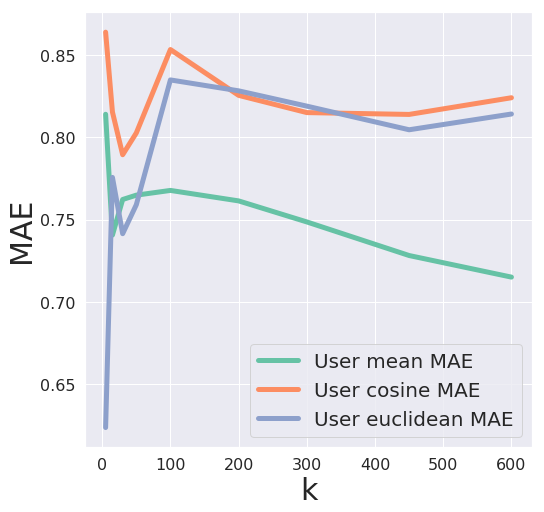

In [21]:
k_array = [5, 15, 30, 50, 100, 200, 300, 450, 600]
user_mean_MAE = []
user_mean_RMSE = []
user_cosine_MAE = []
user_cosine_RMSE = []
user_euc_MAE = []
user_euc_RMSE = []

for k in k_array:
    predicted_user = eval_prediction(users[:50], k, kind = 'user')

    predicted_user = predicted_user[(predicted_user['user_cosine'] > 0) & (predicted_user['user_euclidean'] > 0)]
    
    for name in ['mean_rating', 'user_cosine', 'user_euclidean']:
        if (name == 'mean_rating'):
            user_mean_MAE.append(MAE(predicted_user, 'rating', name))
            user_mean_RMSE.append(RMSE(predicted_user, 'rating', name))
        elif (name == 'user_cosine'):
            user_cosine_MAE.append(MAE(predicted_user, 'rating', name))
            user_cosine_RMSE.append(RMSE(predicted_user, 'rating', name))
        elif (name == 'user_euclidean'):
            user_euc_MAE.append(MAE(predicted_user, 'rating', name))
            user_euc_RMSE.append(RMSE(predicted_user, 'rating', name))

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 3)
plt.figure(figsize=(8, 8))
plt.plot(k_array, user_mean_MAE, c=pal[0], label='User mean MAE', linewidth=5)
plt.plot(k_array, user_cosine_MAE, c=pal[1], label='User cosine MAE', linewidth=5)
plt.plot(k_array, user_euc_MAE, c=pal[2], label='User euclidean MAE', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MAE', fontsize=30);

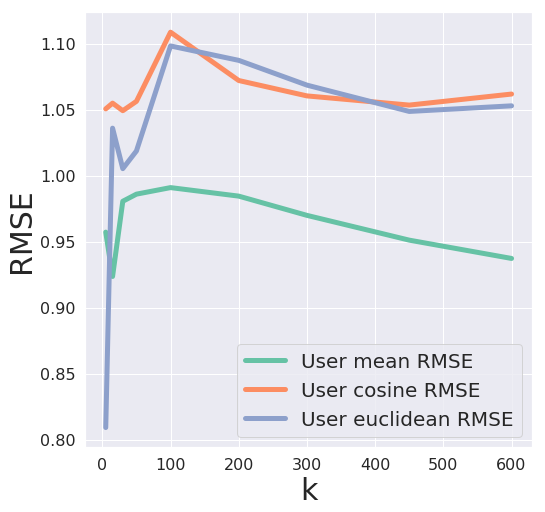

In [22]:
sns.set()

pal = sns.color_palette("Set2", 3)
plt.figure(figsize=(8, 8))
plt.plot(k_array, user_mean_RMSE, c=pal[0], label='User mean RMSE', linewidth=5)
plt.plot(k_array, user_cosine_RMSE, c=pal[1], label='User cosine RMSE', linewidth=5)
plt.plot(k_array, user_euc_RMSE, c=pal[2], label='User euclidean RMSE', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('RMSE', fontsize=30);

In [27]:
print(user_mean_MAE)
print(user_mean_RMSE)
print(user_cosine_MAE)
print(user_cosine_RMSE)
print(user_euc_MAE)
print(user_euc_RMSE)

[0.8139163824099344, 0.7405926344224663, 0.7621903390609203, 0.7648314041630707, 0.7677017701343183, 0.7613435057425079, 0.7485771810309023, 0.7281863774597935, 0.715080363296298]
[0.9572409787226007, 0.9236507948493543, 0.9806314934528203, 0.986027051894072, 0.9909878187637747, 0.9845264471647358, 0.9699475024567609, 0.9511818595297228, 0.9373079326649573]
[0.8637493823882175, 0.8153179689360518, 0.7893634235798733, 0.8025886593552427, 0.8532219285428164, 0.8254110960823956, 0.8149462393809355, 0.8138316489483983, 0.8239577781696523]
[1.0506358995356397, 1.054962806564367, 1.0492472288069898, 1.0563446312278097, 1.1087274857383196, 1.0721158189579347, 1.060457606514587, 1.0534953925509645, 1.0618576040139824]
[0.6237762575738945, 0.775607636877668, 0.741440490749498, 0.7590060476290127, 0.8347703510800835, 0.8281555347237045, 0.8188640533833563, 0.8045167115697027, 0.8140800432277481]
[0.809215283916249, 1.0360220693916211, 1.0053455661953474, 1.0187339841731289, 1.0982994730710058, 1

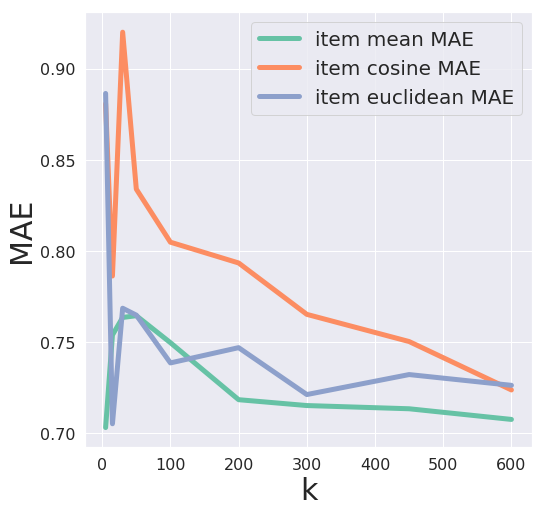

In [25]:
k_array = [5, 15, 30, 50, 100, 200, 300, 450, 600]
item_mean_MAE = []
item_mean_RMSE = []
item_cosine_MAE = []
item_cosine_RMSE = []
item_euc_MAE = []
item_euc_RMSE = []

for k in k_array:
    predicted_item = eval_prediction(users[:20], k, kind = 'item')

    predicted_item = predicted_item[(predicted_item['item_cosine'] > 0) & (predicted_item['item_euclidean'] > 0)]
    
    for name in ['mean_rating', 'item_cosine', 'item_euclidean']:
        if (name == 'mean_rating'):
            item_mean_MAE.append(MAE(predicted_item, 'rating', name))
            item_mean_RMSE.append(RMSE(predicted_item, 'rating', name))
        elif (name == 'item_cosine'):
            item_cosine_MAE.append(MAE(predicted_item, 'rating', name))
            item_cosine_RMSE.append(RMSE(predicted_item, 'rating', name))
        elif (name == 'item_euclidean'):
            item_euc_MAE.append(MAE(predicted_item, 'rating', name))
            item_euc_RMSE.append(RMSE(predicted_item, 'rating', name))

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 3)
plt.figure(figsize=(8, 8))
plt.plot(k_array, item_mean_MAE, c=pal[0], label='item mean MAE', linewidth=5)
plt.plot(k_array, item_cosine_MAE, c=pal[1], label='item cosine MAE', linewidth=5)
plt.plot(k_array, item_euc_MAE, c=pal[2], label='item euclidean MAE', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MAE', fontsize=30);

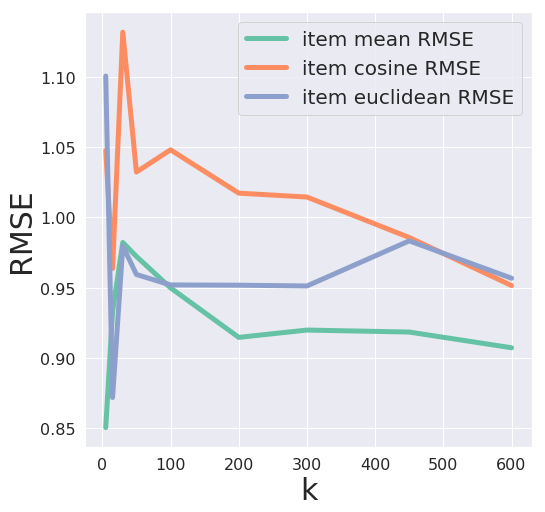

In [26]:
sns.set()

pal = sns.color_palette("Set2", 3)
plt.figure(figsize=(8, 8))
plt.plot(k_array, item_mean_RMSE, c=pal[0], label='item mean RMSE', linewidth=5)
plt.plot(k_array, item_cosine_RMSE, c=pal[1], label='item cosine RMSE', linewidth=5)
plt.plot(k_array, item_euc_RMSE, c=pal[2], label='item euclidean RMSE', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('RMSE', fontsize=30);

In [28]:
print(user_mean_MAE)
print(user_mean_RMSE)
print(user_cosine_MAE)
print(user_cosine_RMSE)
print(user_euc_MAE)
print(user_euc_RMSE)

[0.8139163824099344, 0.7405926344224663, 0.7621903390609203, 0.7648314041630707, 0.7677017701343183, 0.7613435057425079, 0.7485771810309023, 0.7281863774597935, 0.715080363296298]
[0.9572409787226007, 0.9236507948493543, 0.9806314934528203, 0.986027051894072, 0.9909878187637747, 0.9845264471647358, 0.9699475024567609, 0.9511818595297228, 0.9373079326649573]
[0.8637493823882175, 0.8153179689360518, 0.7893634235798733, 0.8025886593552427, 0.8532219285428164, 0.8254110960823956, 0.8149462393809355, 0.8138316489483983, 0.8239577781696523]
[1.0506358995356397, 1.054962806564367, 1.0492472288069898, 1.0563446312278097, 1.1087274857383196, 1.0721158189579347, 1.060457606514587, 1.0534953925509645, 1.0618576040139824]
[0.6237762575738945, 0.775607636877668, 0.741440490749498, 0.7590060476290127, 0.8347703510800835, 0.8281555347237045, 0.8188640533833563, 0.8045167115697027, 0.8140800432277481]
[0.809215283916249, 1.0360220693916211, 1.0053455661953474, 1.0187339841731289, 1.0982994730710058, 1